# **Tutorial 1: Modelling Heat Transfer in Buildings**

## Overview

In this tutorial, we use real-world measurement data [1] to model the heat transfer a building envelope. The data set is public available [here](https://discovery.ucl.ac.uk/id/eprint/10087216/).

By the end of this tutorial, you should be able to:
- Process and interpret building measurement data.
- Formulate data-driven (grey- and black-box) models for building heat transfer.
- Compare and validate different modelling approaches using good-of-fit and statistical metrics.

[1] Hollick, F; Wingfield, J; (2018) Two periods of in-situ measurements from an occupied, semi-detached house in the UK [Dataset]. 10.14324/000.ds.10087216.

# Set up

### Loading libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.optimize import lsq_linear

plt.rcParams['figure.constrained_layout.use'] = True
plt.rcParams['figure.dpi'] = 600
plt.rcParams['figure.figsize'] = (10,4)

### Data processing

We first load and visualize the data. First, set up the ```data_path``` variable to the correct file location and load the data set.

In [2]:
#%% Load measurement data

data_path = 'C:\\Users\\ucbva19\\Git projects\\energy_analytics_built_env\\data raw'
data = pd.read_csv(f'{data_path}\\10mins_solpap.csv', index_col = 0)

### Visualization

Explore the data, check out missing observations.

What do we learn: gas boiler; multiple zones and different temperatures

In [3]:
print(data.head())
print(f'Percentage of missing observations: {100*data.isna().sum()/len(data)}')

                  T_Bath (degC)  T_Bed1 (degC)  T_Bed2 (degC)  El_use (W)  \
Date and time                                                               
11/11/2016 00:00           19.9           17.0           17.2       528.0   
11/11/2016 00:10           20.0           17.1           17.1       288.0   
11/11/2016 00:20           20.0           17.1           17.2       354.0   
11/11/2016 00:30           20.0           17.2           17.3       222.0   
11/11/2016 00:40           20.1           17.3           17.4       396.0   

                  T_Extension (degC)  T_External (degC)  Gas (W)  \
Date and time                                                      
11/11/2016 00:00                15.4                5.0  6817.60   
11/11/2016 00:10                15.3                5.2  4090.56   
11/11/2016 00:20                15.4                5.2   681.76   
11/11/2016 00:30                15.4                5.2  7499.36   
11/11/2016 00:40                15.4                

<Axes: xlabel='Date and time'>

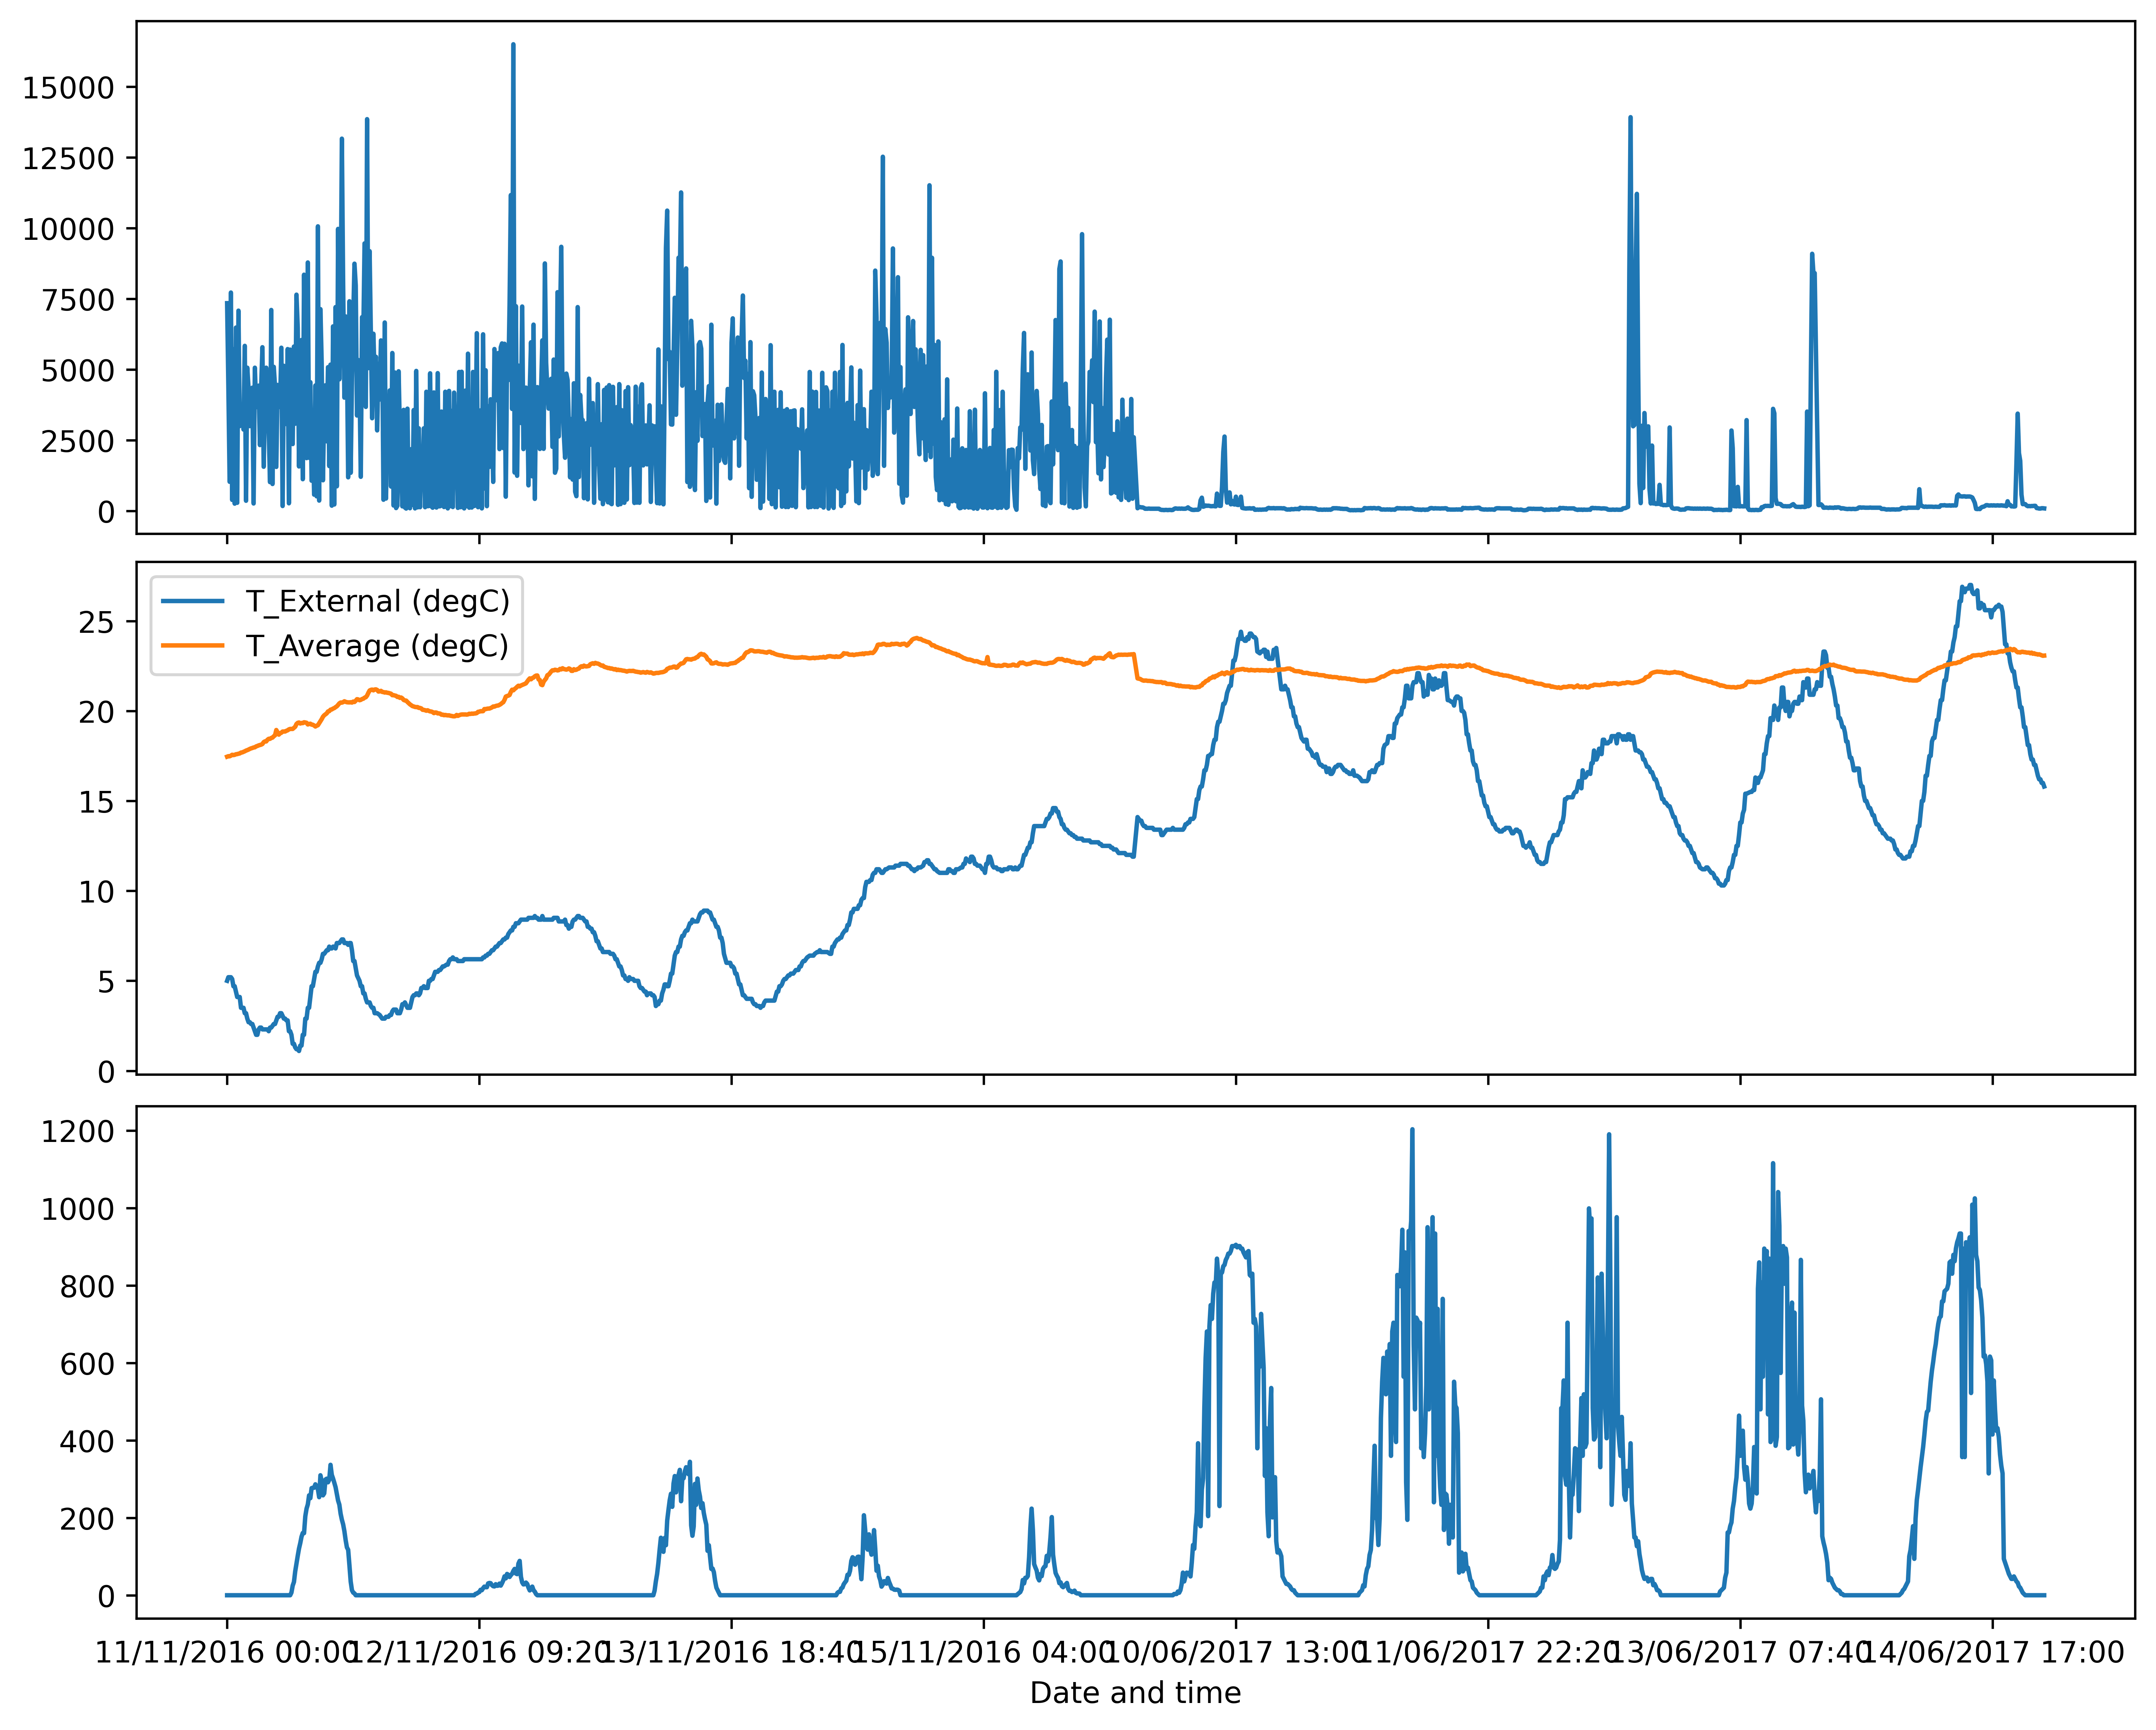

In [4]:
# Keep a subset of features
data = data[['T_External (degC)', 'P_tot (W)', 'Solar (W/m2)', 'T_Average (degC)']]

# Fill missing data with linear interpolation
data = data.interpolate('linear')
assert(data.isna().all().sum() == 0)

# Visualization 
fig, ax = plt.subplots(figsize=(10,8), nrows = 3, sharex = True)

data['P_tot (W)'][:3000].plot(ax=ax[0])
data[:3000][['T_External (degC)', 'T_Average (degC)']].plot(ax=ax[1])
data[:3000]['Solar (W/m2)'].plot(ax = ax[2])

### Modelling heat transfer from data

Assumptions:
- We consider a single zone using the average room temperature, ```T_Average (degC)```, as a proxy.
- We consider a 10-minute discretization step, i.e., $dt=1/6$, which is the same as the data granularity.
- We use the total power, ```P_tot (W)```, as a *proxy* for the net heat injection, which is a simplification. Ideally, we would like to include potential losses. This means that we need to be careful with the physical interpretation of the estimated parameters.

To streamline the code, we introduce auxiliary variables and set up parameters.

In [5]:
# Lead T_in values (target variable)
data['T_Average_lead_1'] = data['T_Average (degC)'].shift(-1)
data['T_diff'] = data['T_External (degC)'] - data['T_Average (degC)']

# Drop NaNs created from the shift operator
data = data.dropna()

# discretization step at 10 minutes
dt_h = 1/6

#### Deriving the $RC$ model

We consider a simple $1R-1C$ model to approximate the thermal dynamics of a single-zone dwelling.:

- $R_{\text{th}}$ = thermal resistance (°C/kW)  
- $C_{\text{th}}$ = thermal capacitance (kWh/°C)
- $\tau = R_{\text{th}} C_{\text{th}}$ = time constant

The continuous-time energy balance is given by

$ C_{\text{th}} \frac{dT}{dt} = \frac{T_\text{ext} - T}{R_{\text{th}}} + H_\text{heat} + g H_\text{solar}$

where $T$ is the average indoor temperature (°C), $T_\text{ext}$ is the external temperature (°C), and $H_\text{heat}$ is the sensible heat injection in the node (kW), $H_\text{solar}$ is the solar radiation, and $g$ is the (unknown) solar gain factor.

Then the dynamics become:

$ \frac{dT}{dt} =
\frac{1}{\tau}(T_\text{ext} - T)
+ \frac{1}{C_{\text{th}}}H_{\text{heat}} + \frac{g}{C_{\text{th}}}H_{\text{solar}}$

Using forward Euler discretization, we get

$
T_{k+1}
=
T_k
+ \Delta t \frac{1}{\tau}(T_{\text{ext},k} - T_k)
+ \Delta t \frac{1}{C_{\text{th}}} H_{\text{heat},k} + \Delta t \frac{g}{C_{\text{th}}} H_{\text{solar},k},
$

where $k$ is the time step index. For convenience, we define the **discrete coefficients**:

$
\alpha_1 = \frac{\Delta t}{\tau}, \qquad
\alpha_2 = \frac{\Delta t}{C_{\text{th}}}, \qquad,
\alpha_3 = \frac{\Delta t g}{C_{\text{th}}}.
$

The final discrete $RC$ model is:

$
T_{k+1} = T_k + \alpha_1\bigl(T_{\text{out},k} - T_k\bigr)
+ \alpha_2 H_{\text{heat},k} + \alpha_3 H_{\text{solar},k}$.

#### Parameter estimation

Next, we estimate the parameters of an $RC$ model, or, equivalently, coefficients $\alpha_{1,2,3}$. Throughout, we use $\hat{\cdot}$ to denote parameters estimated (learned) from data. 
First, for the $k$th observation, we define the loss function

$\ell(\hat{T}_k, T_{k})=(\hat{T}_k-T_{k})^2 = \bigl(T_k + \alpha_1\bigl(T_{\text{out},k} - T_k\bigr)
+ \alpha_2 H_{\text{heat},k} + \alpha_3 H_{\text{solar},k} - T_{k+1}\bigr)^2$, 

which represents the mean squared error (MSE) between predicted temperature $\hat{T}$ and actual temperature $T$.
To estimate the parameters, we minimize the empirical mean squared error over the training data set which contains $N$ observations, 
given by

$\min_{\alpha_{1,2,3}} \sum_{k=1}^{N-1} \ell(\hat{T}_k, T_{k})$, 

which defines a constrained regression problem.
We use the ```lsq_linear``` function to solve this constrained optimization problem.


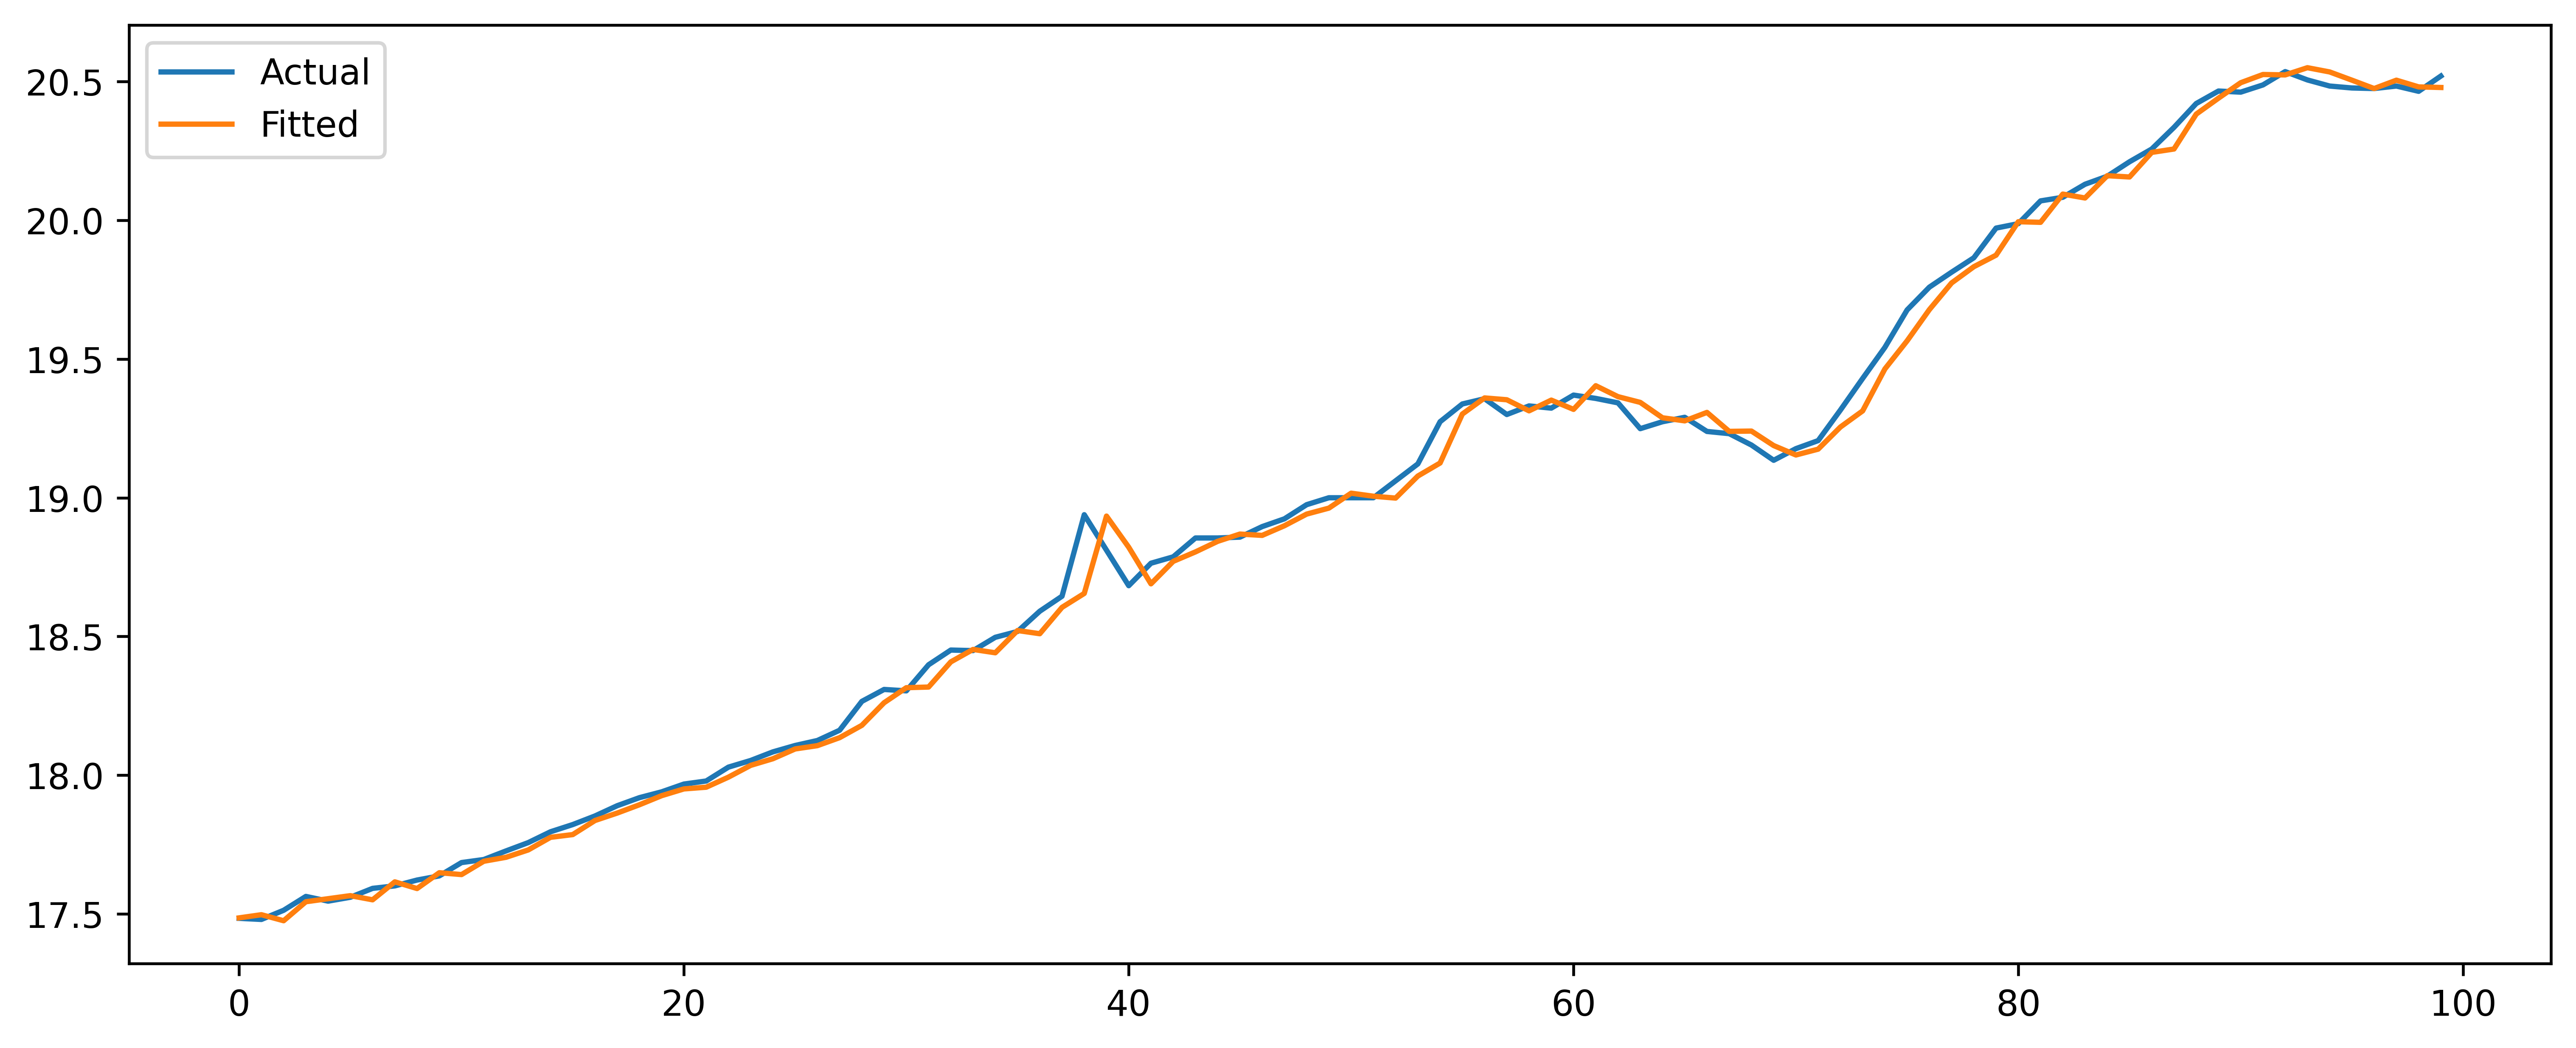

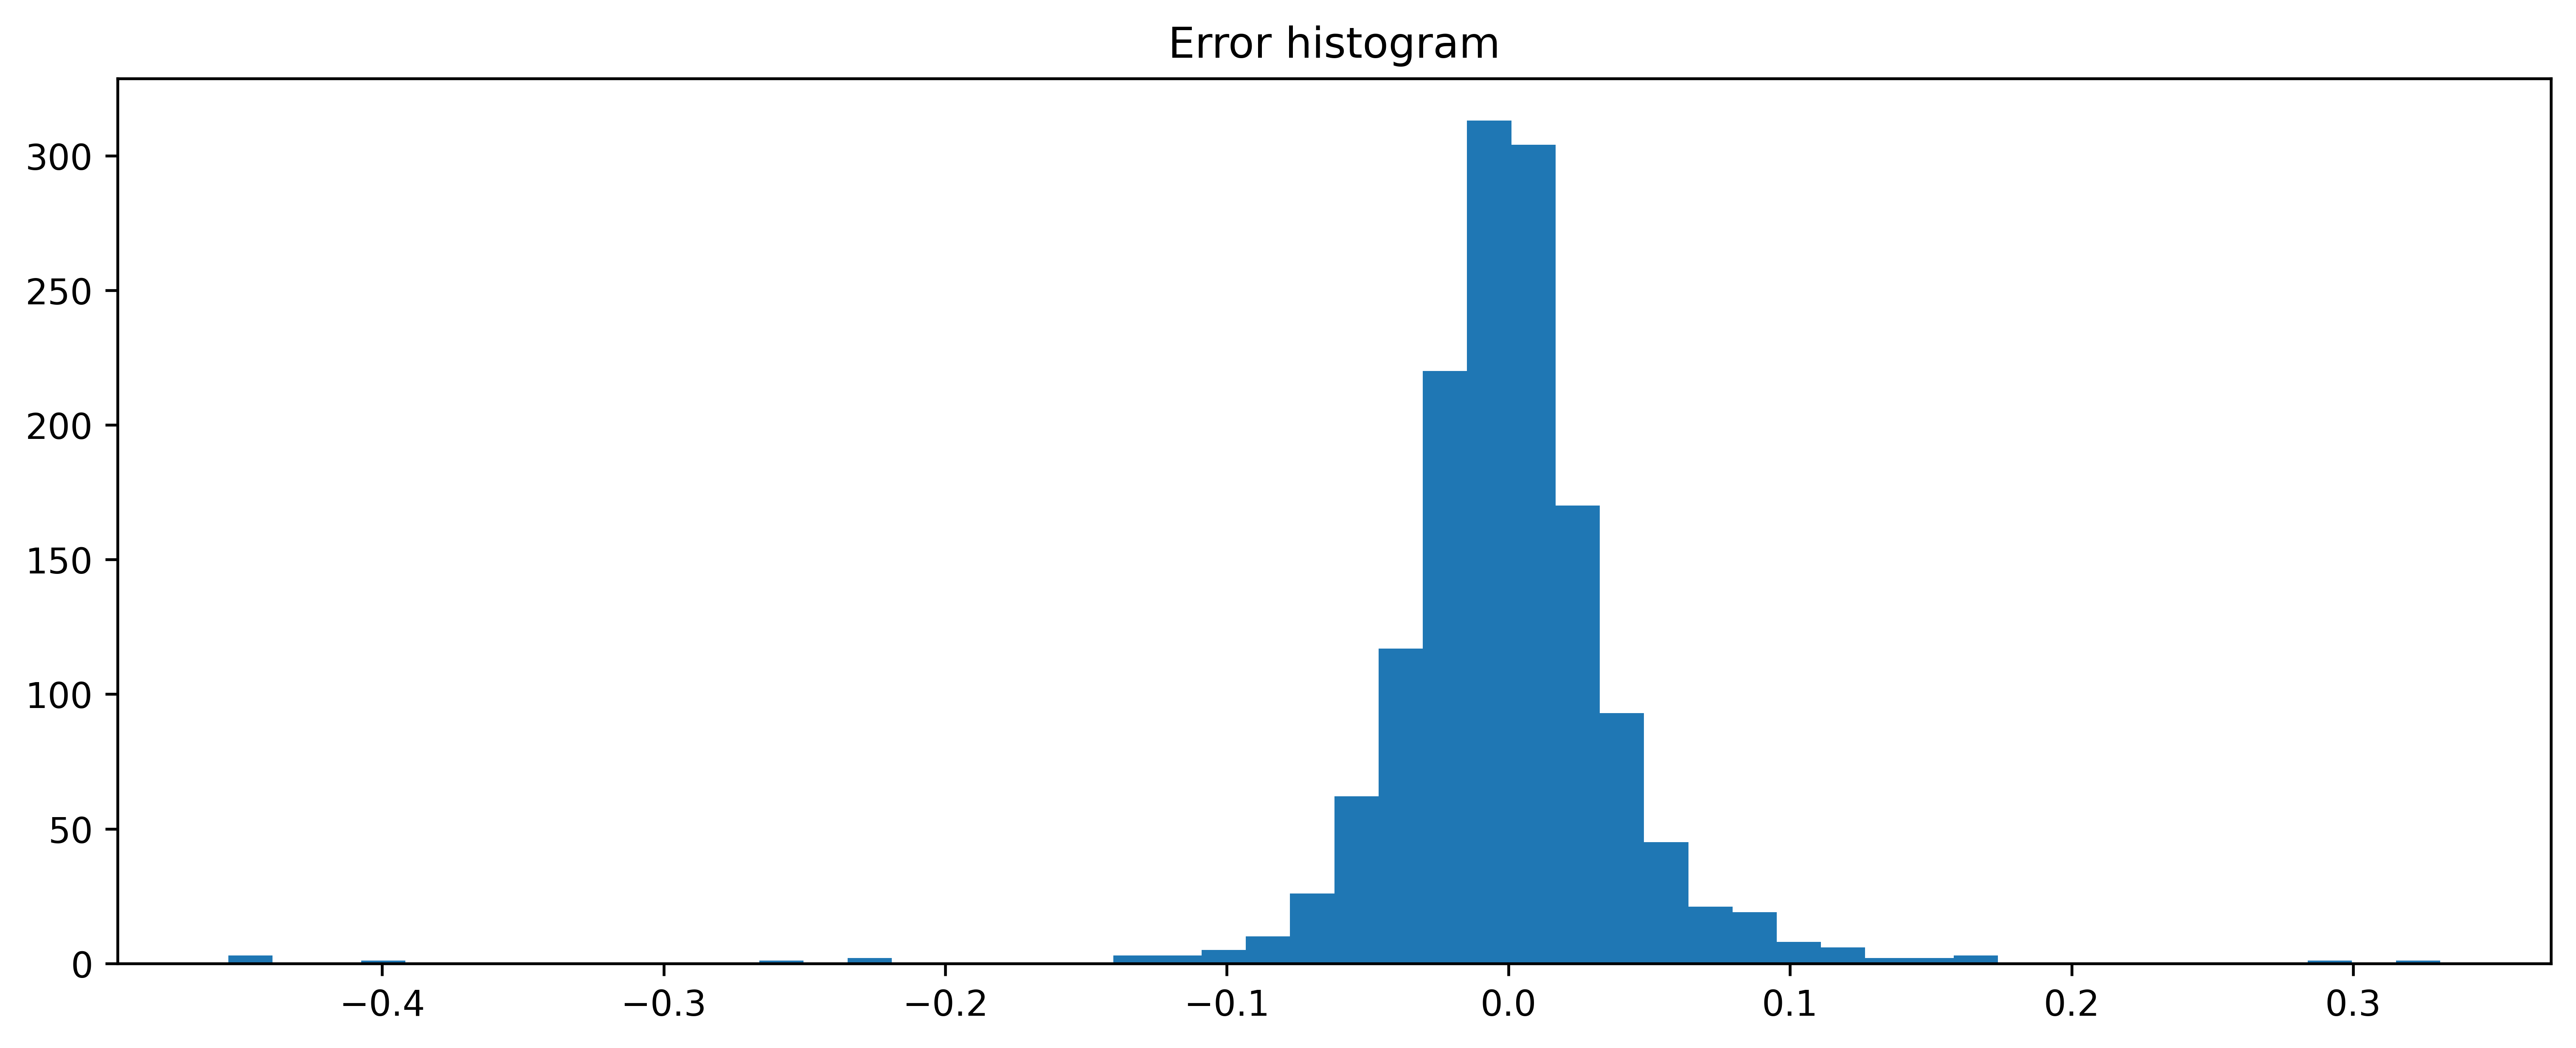

In-sample RMSE
0.04499689727836974
RC parameters
tau:205.07558793826715
C:31398.707880278478
R:0.006531338446161827
g:4.497680169270568


In [6]:
#%% Find parameters for lumped RC model

Y = data['T_Average_lead_1']
X = data[['T_diff', 'P_tot (W)', 'Solar (W/m2)', 'T_Average (degC)']]

# Solve a least-squares optimization problem to estimate RC parameters
A = X.values
b = Y.values

lsq_solution = lsq_linear(A, b, bounds = ([-np.inf, -np.inf, -np.inf, 1-1e-5], [np.inf, np.inf, np.inf, 1]) )

x_coeff = lsq_solution.x

alpha_1 = x_coeff[0]
alpha_2 = x_coeff[1]
alpha_3 = x_coeff[2]

tau = dt_h/alpha_1
C = dt_h/alpha_2
R = tau/C
g = alpha_3/alpha_2

T_fitted = x_coeff@A.T
fit_errors = b - x_coeff@A.T


plt.plot(b[:100], label = 'Actual')
plt.plot(x_coeff@A[:100].T, label = 'Fitted')
plt.legend()
plt.show()

plt.hist(fit_errors, bins = 50, label = 'Errors')
plt.title('Error histogram')
plt.show()

print('In-sample RMSE')
print( np.sqrt(np.square(b - x_coeff@A.T).mean()) )

print('RC parameters')
print(f'tau:{tau}')
print(f'C:{C}')
print(f'R:{R}')
print(f'g:{g}')

#### Linear regression

This section models heat transfer as an (unconstrained) linear regression given by $f(x;\theta) = \theta^\top x$, where $x$ concats all the features used (```['T_diff', 'P_tot (W)', 'Solar (W/m2)', 'T_Average (degC)']```) and $\theta$ are the coefficients.

Questions:
- Will the RMSE be higher or smaller than the $RC$ model above? Why?
- Try to interpret RC parameters from unconstrained linear regression model. What happens? Do the values make sense?

**ToDo**: 
- Estimate $R^2$ and other goodness-of-fit measures
- Add a nonlinear ML model, e.g., $xgboost$
- Implement the experiment at lower granularity, e.g., hourly observations, check findings.
- Clarification on coefficients and 

In [7]:
# Redefine feature vector
Y = data['T_Average_lead_1']
X = data[['T_diff', 'P_tot (W)', 'Solar (W/m2)', 'T_Average (degC)']]

lr = LinearRegression(fit_intercept = False).fit(X, Y)

print('In-sample RMSE')
print( np.sqrt(np.square(Y - lr.predict(X)).mean()) )

tau = dt_h/lr.coef_[0]
C = dt_h/lr.coef_[1]
R = tau/C

print('RC parameters')
print(f'tau:{tau}')
print(f'C:{C}')
print(f'R:{R}')

In-sample RMSE
0.04480516599775264
RC parameters
tau:-8527.613888264472
C:32770.2520666434
R:-0.26022423846243975
